In [1]:
import torch

In [2]:
import cv2
import torch
import torch.nn.functional as F
import numpy as np
from torchvision import transforms

# Constants
IMG_SIZE = 224
NUM_FRAMES = 64
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Preprocessing for a video
def preprocess_video(video_path):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames - 1, NUM_FRAMES).astype(int)

    frames = []
    idx = 0
    ret = True
    while ret and len(frames) < NUM_FRAMES:
        ret, frame = cap.read()
        if idx in frame_indices:
            frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = frame / 255.0
            frames.append(frame)
        idx += 1

    cap.release()

    if len(frames) < NUM_FRAMES:
        # Pad with last frame if video is too short
        frames += [frames[-1]] * (NUM_FRAMES - len(frames))

    frames = np.stack(frames)
    frames = torch.tensor(frames, dtype=torch.float32).permute(0, 3, 1, 2)  # [T, C, H, W]
    frames = frames.unsqueeze(0)  # [1, T, C, H, W]
    return frames.to(DEVICE)


In [3]:

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import glob
import os
import torch.nn as nn


# Memory-efficient feature extractor using EfficientNet
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

class FeatureExtractor(nn.Module):
    def __init__(self, pretrained=True):
        super(FeatureExtractor, self).__init__()
        # Use ConvNeXt instead of EfficientNet
        weights = ConvNeXt_Tiny_Weights.IMAGENET1K_V1 if pretrained else None
        base_model = convnext_tiny(weights=weights)
        # Remove the classification layer
        self.model = nn.Sequential(*list(base_model.children())[:-1])
        self.feature_dim = 768  # ConvNeXt tiny output dimension

    def forward(self, x):
        batch_size, seq_len, c, h, w = x.shape

        # Process frames in chunks to save memory
        features = []
        chunk_size = 4  # Process 4 frames at a time

        for i in range(0, seq_len, chunk_size):
            end_idx = min(i + chunk_size, seq_len)
            chunk = x[:, i:end_idx].reshape(-1, c, h, w)  # Reshape chunk

            # Extract features
            with torch.cuda.amp.autocast(enabled=True):  # Use mixed precision
                chunk_features = self.model(chunk)

            # Reshape back
            chunk_features = chunk_features.reshape(batch_size, end_idx - i, -1)
            features.append(chunk_features)

            # Clear unnecessary tensors to free memory
            del chunk, chunk_features
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        # Concatenate chunks
        x = torch.cat(features, dim=1)
        return x

# Improved temporal modeling with reduced complexity
class TemporalAttention(nn.Module):
    def __init__(self, feature_dim, num_heads=4, dropout=0.1):  # Reduced heads
        super(TemporalAttention, self).__init__()
        self.self_attn = nn.MultiheadAttention(feature_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(feature_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Apply self-attention with residual connection
        attn_output, _ = self.self_attn(x, x, x)
        x = x + self.dropout(attn_output)
        x = self.norm1(x)
        return x

# Simplified sequence model
class TemporalSequenceModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=384, num_layers=1, dropout=0.5):  # Reduced complexity
        super(TemporalSequenceModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0)
        self.attention = TemporalAttention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, 2)  # 2 classes
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(hidden_dim)

    def forward(self, x):
        # Process with LSTM
        lstm_out, _ = self.lstm(x)

        # Apply attention
        attn_out = self.attention(lstm_out)

        # Global temporal pooling
        pooled = torch.mean(attn_out, dim=1)

        # Apply normalization and dropout
        pooled = self.norm(pooled)
        pooled = self.dropout(pooled)

        # Final classification
        x = self.fc(pooled)

        return x

class ViolenceDetectionModel(nn.Module):
    def __init__(self, feature_dim=768):  # Updated feature dim for ConvNeXt tiny
        super(ViolenceDetectionModel, self).__init__()
        self.feature_extractor = FeatureExtractor(pretrained=True)
        self.feature_dim = feature_dim
        self.sequence_model = TemporalSequenceModel(input_dim=feature_dim)



        # Freeze feature extractor layers for initial training
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def forward(self, x):
        features = self.feature_extractor(x)
        prediction = self.sequence_model(features)
        return prediction

In [4]:
def load_trained_model(model_class, checkpoint_path, device='cuda'):
    model = model_class()
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    return model


In [5]:
from numpy.core.multiarray import scalar
from torch.serialization import safe_globals

def classify_video(video_path, model_weights_path):
    model = ViolenceDetectionModel().to(DEVICE)

    # Explicitly allow numpy scalar type for unpickling
    with safe_globals([scalar]):
        checkpoint = torch.load(model_weights_path, map_location=DEVICE, weights_only=False)

    model.load_state_dict(checkpoint['model_state_dict'])

    model.eval()
    with torch.no_grad():
        video_tensor = preprocess_video(video_path).to(DEVICE)
        output = model(video_tensor)
        pred_class = torch.argmax(output, dim=1).item()
        confidence = torch.softmax(output, dim=1)[0, pred_class].item()

    classes = ["Non-Violent", "Violent"]
    return classes[pred_class], confidence


In [20]:
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

def display_video(video_path, delay=0.05):
    """
    Display a video frame by frame using matplotlib
    
    Args:
        video_path: Path to the video file
        delay: Delay between frames in seconds (controls playback speed)
    """
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error: Could not open video at {video_path}")
        return
    
    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count / fps
    
    print(f"Video loaded: {frame_count} frames at {fps} fps (duration: {duration:.2f}s)")
    
    plt.figure(figsize=(12, 8))
    
    # Read and display frames
    while cap.isOpened():
        ret, frame = cap.read()
        
        if not ret:
            break
            
        # Convert BGR (OpenCV format) to RGB (matplotlib format)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Display the frame
        clear_output(wait=True)
        plt.imshow(rgb_frame)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Add delay to control playback speed
        time.sleep(delay)
    
    # Release resources
    cap.release()
    plt.close()



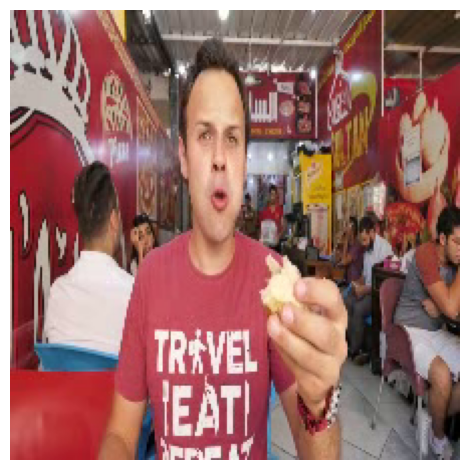

C:\Users\harsh\AppData\Local\Temp\ipykernel_1976\4153649132.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):  # Use mixed precision


('Non-Violent', 0.9999547004699707)

In [21]:
video_path = r"C:\Users\harsh\Downloads\presentation\holdout_videos_20250423_202948\NV_794.mp4"
model_weights_path =r"C:\Users\harsh\Downloads\presentation\best_violence_detector(1).pth"

display_video(video_path)

classify_video(video_path, model_weights_path)

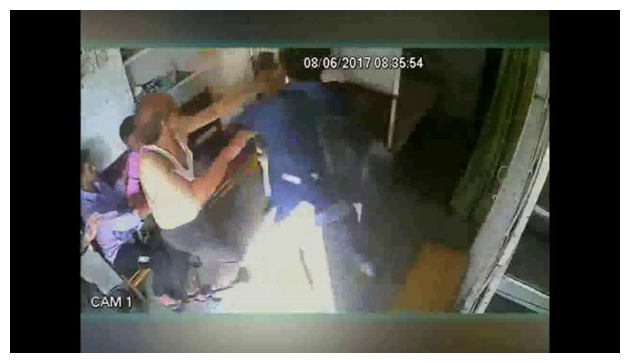

C:\Users\harsh\AppData\Local\Temp\ipykernel_1976\4153649132.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):  # Use mixed precision


('Violent', 0.9997410178184509)

In [44]:
video_path = r"C:\Users\harsh\Downloads\presentation\holdout_videos_20250423_202948\Violence-Test090.avi"
model_weights_path =r"C:\Users\harsh\Downloads\presentation\best_violence_detector(1).pth"
display_video(video_path)

classify_video(video_path, model_weights_path)

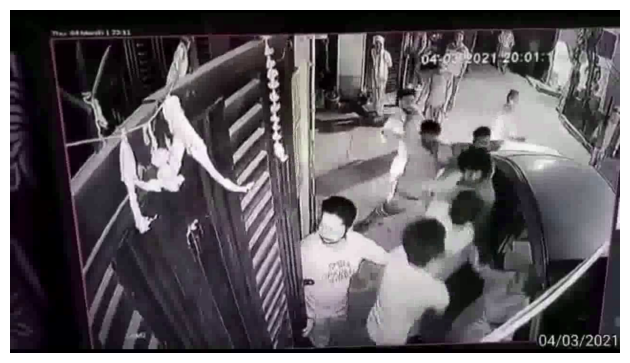

C:\Users\harsh\AppData\Local\Temp\ipykernel_1976\4153649132.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):  # Use mixed precision


('Violent', 0.9997376799583435)

In [45]:
video_path = r"C:\Users\harsh\Downloads\presentation\holdout_videos_20250423_202948\Violence860.avi"
model_weights_path =r"C:\Users\harsh\Downloads\presentation\best_violence_detector(1).pth"
display_video(video_path)

classify_video(video_path, model_weights_path)

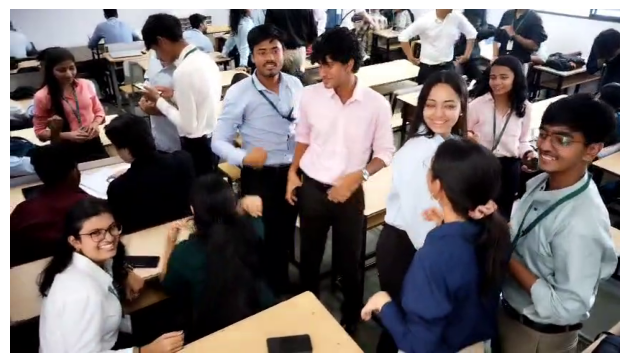

C:\Users\harsh\AppData\Local\Temp\ipykernel_1976\4153649132.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):  # Use mixed precision


('Violent', 0.9997180104255676)

In [47]:
video_path = r"C:\Users\harsh\Downloads\presentation\v.mp4"
model_weights_path =r"C:\Users\harsh\Downloads\presentation\best_violence_detector(1).pth"
display_video(video_path)

classify_video(video_path, model_weights_path)

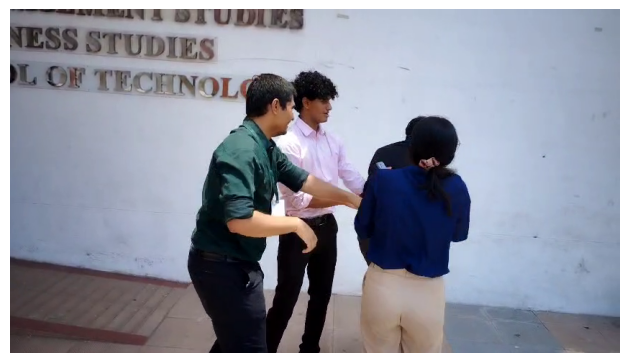

C:\Users\harsh\AppData\Local\Temp\ipykernel_1976\4153649132.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):  # Use mixed precision


('Violent', 0.9997614026069641)

In [48]:
video_path = r"C:\Users\harsh\Downloads\presentation\v2.mp4"
model_weights_path =r"C:\Users\harsh\Downloads\presentation\best_violence_detector(1).pth"
display_video(video_path)

classify_video(video_path, model_weights_path)

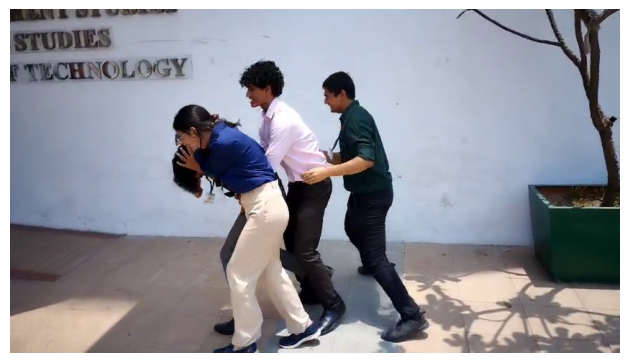

C:\Users\harsh\AppData\Local\Temp\ipykernel_1976\4153649132.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):  # Use mixed precision


('Violent', 0.9994375109672546)

In [39]:
video_path = r"C:\Users\harsh\Downloads\presentation\v3.mp4"
model_weights_path =r"C:\Users\harsh\Downloads\presentation\best_violence_detector(1).pth"
display_video(video_path)

classify_video(video_path, model_weights_path)

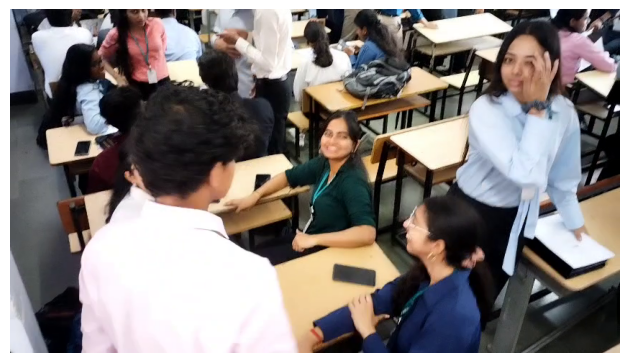

C:\Users\harsh\AppData\Local\Temp\ipykernel_1976\4153649132.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):  # Use mixed precision


('Non-Violent', 0.9999654293060303)

In [41]:
video_path = r"C:\Users\harsh\Downloads\presentation\nv.mp4"
model_weights_path =r"C:\Users\harsh\Downloads\presentation\best_violence_detector(1).pth"
display_video(video_path)

classify_video(video_path, model_weights_path)

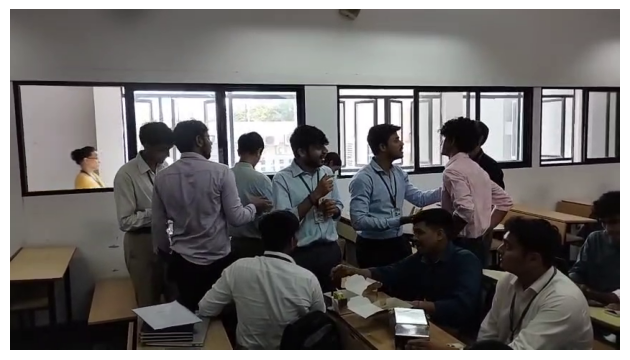

C:\Users\harsh\AppData\Local\Temp\ipykernel_1976\4153649132.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):  # Use mixed precision


('Non-Violent', 0.9999637603759766)

In [49]:
video_path = r"C:\Users\harsh\Downloads\presentation\nv2.mp4"
model_weights_path =r"C:\Users\harsh\Downloads\presentation\best_violence_detector(1).pth"
display_video(video_path)

classify_video(video_path, model_weights_path)

In [ ]:
video_path = r"C:\Users\harsh\Downloads\presentation\v4.mp4"
model_weights_path =r"C:\Users\harsh\Downloads\presentation\best_violence_detector(1).pth"
display_video(video_path)

classify_video(video_path, model_weights_path)